In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from os.path import join #데이터를 불러오기 위해
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #데이터를 불러오기 위해
print("import 완료!!")

import 완료!!


## 포지셔널 인코딩(positional Encoding)

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("포지셔널 인코딩 레이어")

포지셔널 인코딩 레이어


### 행의 크기가 50, 열의 크기가 512인 행렬 그리기

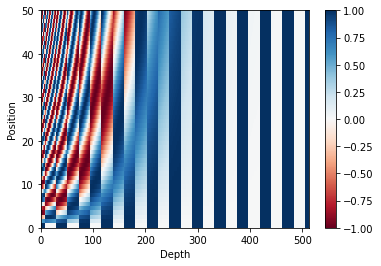

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 스케일드 닷 프로덕트 어텐션 함수

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("스케일드 닷 프로덕트 어텐션 함수")

스케일드 닷 프로덕트 어텐션 함수


## 멀티-헤드 어텐션

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("멀티해드어텐션")

멀티해드어텐션


## 패딩 마스킹

In [6]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("패딩 마스킹")

패딩 마스킹


## 트랜스포머

In [7]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("룩 어헤드 마스킹")

룩 어헤드 마스킹


## 인코더 층 만들기

In [8]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("인코더 층 만들기")

인코더 층 만들기


## 인코더 층을 쌓아 인코더 만들기

In [9]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("인코더 만들기")

인코더 만들기


## 디코더 층 만들기

In [10]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("디코더 층 만들기")

디코더 층 만들기


## 디코더 층을 쌓아 디코더 만들기

In [11]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("디코더 만들기")

디코더 만들기


# Step 1. 데이터 수집하기

#### mkdir -p ~/aiffel/transformer_chatbot/data/
#### ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

In [12]:
train_data_dir = os.getenv('HOME')+'/aiffel/songys_chatbot'

train_data_path = join(train_data_dir, 'ChatbotData.csv')

train_data = pd.read_csv(train_data_path)

print("데이터 가져오기 완료")

데이터 가져오기 완료


In [13]:
#데이터 확인하기
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [14]:
#데이터 갯수 확인하기
print(len(train_data))

11823


# Step 2. 데이터 전처리하기

In [15]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
print('전처리 완료1')

전처리 완료1


In [16]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    for i in range(len(train_data)):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(train_data['Q'].values[i]))
        outputs.append(preprocess_sentence(train_data['A'].values[i]))
    return inputs, outputs
print('전처리 완료2')

전처리 완료2


In [17]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [18]:
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[0]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[0]))

전처리 후의 1번째 질문 샘플: 12시 땡 !
전처리 후의 1번째 답변 샘플: 하루가 또 가네요 .


# Step 3. SubwordTextEncoder 사용하기

In [19]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [20]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8162]
END_TOKEN의 번호 : [8163]


In [21]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8164


In [22]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5756, 610, 2486, 4158]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7502, 7, 6266, 97, 1]


질문의 최대 길이 : 16
질문의 평균 길이 : 3.9378330373001775
대답의 최대 길이 : 24
대답의 평균 길이 : 4.716146494121627


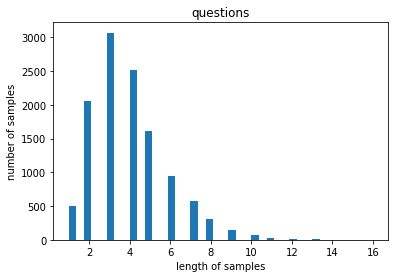

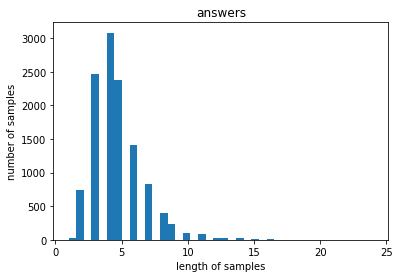

In [23]:
#최대길이와 평균길이를 확인하기 위해 그래프 그리기
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]

print('질문의 최대 길이 : {}'.format(np.max(questions_len)))
print('질문의 평균 길이 : {}'.format(np.mean(questions_len)))
print('대답의 최대 길이 : {}'.format(np.max(answers_len)))
print('대답의 평균 길이 : {}'.format(np.mean(answers_len)))

plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

막대 그래프에 의하면, answers에 글자수가 9를 넘어가는 데이터는 그렇게 많지 않다. 그래서 MAX_LENGTH = 9로 설정한다.

In [24]:
MAX_LENGTH = 9
print(MAX_LENGTH)

9


In [25]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [26]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 7820
필터링 후의 답변 샘플 개수: 7820


In [88]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("교사 강요 사용하기")

교사 강요 사용하기


In [28]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("모델 정의 및 학습 완료")

모델 정의 및 학습 완료


# Step 4. 모델 구성하기

In [29]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3144192     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [30]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("손실함수")

손실함수


In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("커스텀된 학습률")

커스텀된 학습률


Text(0.5, 0, 'Train Step')

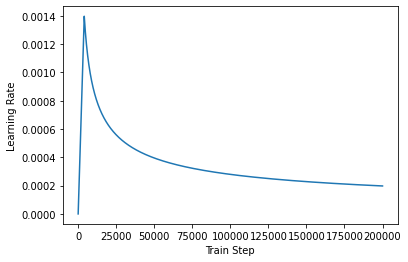

In [32]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [34]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("모델 컴파일")

모델 컴파일


In [35]:
EPOCHS = 70
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/70
123/123 [==============================] - 9s 26ms/step - loss: 6.0670 - accuracy: 0.0966
Epoch 2/70
123/123 [==============================] - 3s 25ms/step - loss: 5.2089 - accuracy: 0.2104
Epoch 3/70
123/123 [==============================] - 3s 26ms/step - loss: 4.3695 - accuracy: 0.2400
Epoch 4/70
123/123 [==============================] - 3s 25ms/step - loss: 3.8468 - accuracy: 0.2429
Epoch 5/70
123/123 [==============================] - 3s 25ms/step - loss: 3.5596 - accuracy: 0.2499
Epoch 6/70
123/123 [==============================] - 3s 25ms/step - loss: 3.3584 - accuracy: 0.2607
Epoch 7/70
123/123 [==============================] - 3s 25ms/step - loss: 3.1646 - accuracy: 0.2737
Epoch 8/70
123/123 [==============================] - 3s 25ms/step - loss: 2.9646 - accuracy: 0.2921
Epoch 9/70
123/123 [==============================] - 3s 25ms/step - loss: 2.7497 - accuracy: 0.3187
Epoch 10/70
123/123 [==============================] - 3s 25ms/step - loss: 2.5095 - accura

# Step 5. 모델 평가하기

In [36]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("챗봇 테스트하기1")

챗봇 테스트하기1


In [37]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("챗봇 테스트하기2")

챗봇 테스트하기2


In [38]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

In [39]:
sentence_generation('오늘 숙제 뭐야?')

입력 : 오늘 숙제 뭐야?
출력 : 지금도 늦지 않았어요 .


'지금도 늦지 않았어요 .'

In [40]:
sentence_generation('오늘 뭐먹지?')

입력 : 오늘 뭐먹지?
출력 : 색다른걸 드셔보세요 .


'색다른걸 드셔보세요 .'

#### 생각보다 답변이 잘나와서 놀랐다!
#### 오늘 숙제 뭐야?라는 질문에 '지금도 늦지 않았어요'라는 대답은 조금 안 맞는 것 같아서, 모델 수정 다시하기!

# Step 6. 모델 수정하기 01
### EPOCHS = 120 / NUM_LAYERS = 4

In [43]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4198400     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [45]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("모델 컴파일")

모델 컴파일


In [46]:
EPOCHS = 120
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/120
123/123 [==============================] - 17s 46ms/step - loss: 5.9908 - accuracy: 0.1088
Epoch 2/120
123/123 [==============================] - 6s 46ms/step - loss: 5.1402 - accuracy: 0.2288
Epoch 3/120
123/123 [==============================] - 6s 47ms/step - loss: 4.3287 - accuracy: 0.2410
Epoch 4/120
123/123 [==============================] - 6s 46ms/step - loss: 3.8256 - accuracy: 0.2426
Epoch 5/120
123/123 [==============================] - 6s 46ms/step - loss: 3.5855 - accuracy: 0.2493
Epoch 6/120
123/123 [==============================] - 6s 46ms/step - loss: 3.4329 - accuracy: 0.2573
Epoch 7/120
123/123 [==============================] - 6s 46ms/step - loss: 3.2880 - accuracy: 0.2662
Epoch 8/120
123/123 [==============================] - 6s 46ms/step - loss: 3.1315 - accuracy: 0.2758
Epoch 9/120
123/123 [==============================] - 6s 46ms/step - loss: 2.9524 - accuracy: 0.2908
Epoch 10/120
123/123 [==============================] - 6s 47ms/step - loss: 2.75

In [47]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output_sequence = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("챗봇 테스트하기1")

챗봇 테스트하기1


In [48]:
def sentence_generation(sentence):
  prediction = decoder_inference(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("챗봇 테스트하기2")

챗봇 테스트하기2


In [49]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 고생 많았어요 .


'고생 많았어요 .'

In [50]:
sentence_generation('오늘 숙제 뭐야?')

입력 : 오늘 숙제 뭐야?
출력 : 미리미리 해야죠 .


'미리미리 해야죠 .'

In [51]:
sentence_generation('오늘 뭐먹지?')

입력 : 오늘 뭐먹지?
출력 : 색다른걸 드셔보세요 .


'색다른걸 드셔보세요 .'

In [53]:
sentence_generation('우울해')

입력 : 우울해
출력 : 많이 힘들었죠 .


'많이 힘들었죠 .'

In [56]:
sentence_generation('너무 귀엽다')

입력 : 너무 귀엽다
출력 : 친구가 보는 눈이 있네요 .


'친구가 보는 눈이 있네요 .'

#### EPOCHS = 120 / NUM_LAYERS = 4로 했지만, 정확도도 그렇게 높아지지 않았다.
#### 정확도를 보면 EPOCHS가 도는 동안 올라갔다 내려갔다 해서 그렇게 잘 훈련이 된 것 같지 않았다.
#### 또한, 오늘 날씨 어때?라는 질문에 '고생 많았어요 .'라는 답변은 좀 이상하다. 아까 EPOCHS = 70일때의 답변이 더 낫다

# Step 6. 모델 수정하기 02
### EPOCHS = 100 / NUM_LAYERS = 2

In [59]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3144192     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [60]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("모델 컴파일")

모델 컴파일


In [61]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
123/123 [==============================] - 9s 25ms/step - loss: 6.0830 - accuracy: 0.0913
Epoch 2/100
123/123 [==============================] - 3s 25ms/step - loss: 5.2095 - accuracy: 0.2120
Epoch 3/100
123/123 [==============================] - 3s 25ms/step - loss: 4.3549 - accuracy: 0.2411
Epoch 4/100
123/123 [==============================] - 3s 25ms/step - loss: 3.8259 - accuracy: 0.2432
Epoch 5/100
123/123 [==============================] - 3s 25ms/step - loss: 3.5489 - accuracy: 0.2514
Epoch 6/100
123/123 [==============================] - 3s 25ms/step - loss: 3.3505 - accuracy: 0.2617
Epoch 7/100
123/123 [==============================] - 3s 25ms/step - loss: 3.1590 - accuracy: 0.2739
Epoch 8/100
123/123 [==============================] - 3s 24ms/step - loss: 2.9578 - accuracy: 0.2921
Epoch 9/100
123/123 [==============================] - 3s 25ms/step - loss: 2.7419 - accuracy: 0.3158
Epoch 10/100
123/123 [==============================] - 3s 24ms/step - loss: 2.500

In [62]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output_sequence = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("챗봇 테스트하기1")

챗봇 테스트하기1


In [63]:
def sentence_generation(sentence):
  prediction = decoder_inference(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("챗봇 테스트하기2")

챗봇 테스트하기2


In [64]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

In [65]:
sentence_generation('오늘 숙제 뭐야?')

입력 : 오늘 숙제 뭐야?
출력 : 미리미리 해야죠 .


'미리미리 해야죠 .'

In [66]:
sentence_generation('오늘 뭐먹지?')

입력 : 오늘 뭐먹지?
출력 : 색다른걸 드셔보세요 .


'색다른걸 드셔보세요 .'

In [68]:
sentence_generation('우울해')

입력 : 우울해
출력 : 많이 힘들었죠 .


'많이 힘들었죠 .'

In [71]:
sentence_generation('너무 귀엽다')

입력 : 너무 귀엽다
출력 : 친구가 보는 눈이 있네요 .


'친구가 보는 눈이 있네요 .'

In [73]:
sentence_generation('안녕?')

입력 : 안녕?
출력 : 안녕하세요 .


'안녕하세요 .'

In [74]:
sentence_generation('사랑해')

입력 : 사랑해
출력 : 하늘 만큼 땅 만큼 사랑해요 .


'하늘 만큼 땅 만큼 사랑해요 .'

In [78]:
sentence_generation('입을 옷이 없어')

입력 : 입을 옷이 없어
출력 : 옷은 사도 사도 모자라요 .


'옷은 사도 사도 모자라요 .'

In [83]:
sentence_generation('게임하고 싶어')

입력 : 게임하고 싶어
출력 : 게임하세요 !


'게임하세요 !'

In [85]:
sentence_generation('공부하는 시간이 너무 길어')

입력 : 공부하는 시간이 너무 길어
출력 : 공부 도와달라고 해보세요 .


'공부 도와달라고 해보세요 .'

In [86]:
sentence_generation('항상 고마워')

입력 : 항상 고마워
출력 : 감사합니다 .


'감사합니다 .'

In [87]:
sentence_generation('어제 아빠가 뭐라고 하셨어?')

입력 : 어제 아빠가 뭐라고 하셨어?
출력 : 사회생활로 힘드신가봐요 .


'사회생활로 힘드신가봐요 .'

#### 다들 하이퍼파라미터를 수정하는 건 결과물이 좋지 않다고 해서 다시 원래대로 돌리고, 대신에 EPOCHS = 100으로 바꾸었다.
#### 100인 이유는 그게 제일 정확도가 높은 것 같아서 였다.
#### 이것저것 질문을 해봤지만 생각보다 답변이 잘나와서 좋았다.
#### 수정은 안해도 될것 같다

# REPORT
#### 이번에는 루브릭 3개를 다 통과할꺼 같다!!!
#### 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행했고,
#### 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴했고,
#### 한국어 입력문장에 그럴듯한 한국어로 답변을 리턴했다!!
#### 사실 이번 프로젝트에서 제일 힘들었던 것은.. 다름아닌,
#### 전처리 부분이었다.
#### 분명히 제대로 작성을 했는데 이상하게 '데이터와 구두점 사이의 거리'에 공백이 생기질 않았다.
#### 성돈님, 아람님, 동휘님, 지영님이 같이 머리 싸매고 같이 고민해주셔서 해결할 수 있었다.
#### 아마 train_data['Q'].values[i] <-이렇게 작성해야 되는데 train_data['Q'[i]] 이렇게 작성해서 안된 것 같았다.
#### 이후에 막대 그래프를 그릴때 'numpy.ndarray' object has no attribute 'split'라는 오류가 떠서 구글도 찾아보고 그랬는데 뭔가 개운하게 답변을 찾을 수 없었다.
#### 성돈님이 한번 다시 돌려보는게 어떻냐고 하셔서 다시 돌렸더니 해결이 되었다... (이상하게 그 전에는 몇번이나 다시 했지만 안됐었다) 이렇게 잘 해결해서 노드도 잘 끝냈다!!


